## Code to train DQN with APSF representations

Note: to run the network on a different environment, you will have to change the layout inside fourrooms.py located in the deep_rl_old library file.

In [1]:
# Add location to DeepRL library (based on a 2019 version of the library)
import sys,os
sys.path.append('../..')

from deep_rl_old import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Training a baseline DQN

In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    if(config.hidden_nodes is None):
        hidden_nodes = 16
    else:
        hidden_nodes = config.hidden_nodes
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, \
                                                                     hidden_units=(hidden_nodes,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)

2020-11-28 15:53:39,735 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-11-28 15:53:44,718 - root - INFO: steps 5000, episodic_return_test -180.50(18.50)
2020-11-28 15:53:48,286 - root - INFO: steps 10000, episodic_return_test -160.60(24.92)
2020-11-28 15:53:51,862 - root - INFO: steps 15000, episodic_return_test -160.40(25.05)
2020-11-28 15:53:55,310 - root - INFO: steps 20000, episodic_return_test -83.10(30.19)
2020-11-28 15:53:58,673 - root - INFO: steps 25000, episodic_return_test -44.50(24.61)
2020-11-28 15:54:02,025 - root - INFO: steps 30000, episodic_return_test -44.70(24.56)
2020-11-28 15:54:05,427 - root - INFO: steps 35000, episodic_return_test -65.20(27.94)
2020-11-28 15:54:08,721 - root - INFO: steps 40000, episodic_return_test -4.50(1.22)
2020-11-28 15:54:12,037 - root - INFO: steps 45000, episodic_return_test -7.90(1.48)
2020-11-28 15:54:15,387 - root - INFO: steps 50000, episodic_return_test -29.60(18.00)


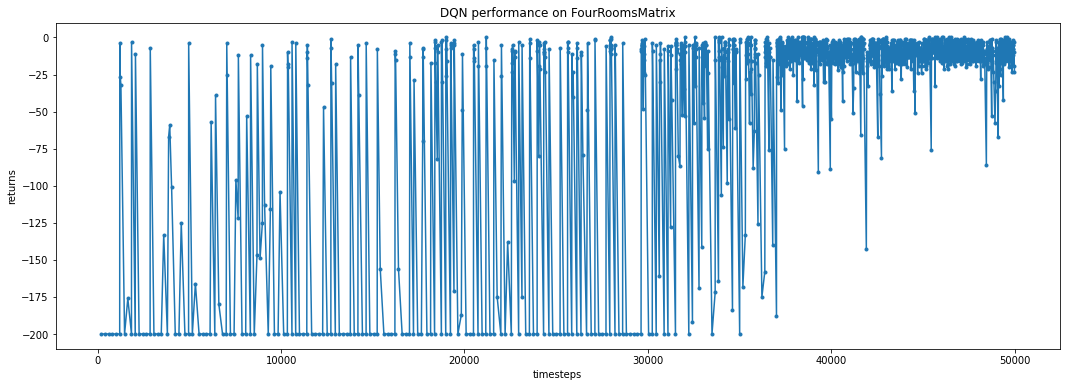

(Text(0.5, 1.0, 'DQN performance on FourRoomsMatrix'), None)

In [4]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

### Learning the state representations using APSF (unsupervised exploration)

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()

In [6]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2020-11-28 15:54:34,215 - root - INFO: steps 0, 466033777.78 steps/s
2020-11-28 15:54:35,550 - root - INFO: steps 1000, 751.33 steps/s
2020-11-28 15:54:36,842 - root - INFO: steps 2000, 776.57 steps/s
2020-11-28 15:54:38,133 - root - INFO: steps 3000, 777.20 steps/s
2020-11-28 15:54:39,401 - root - INFO: steps 4000, 790.67 steps/s
2020-11-28 15:54:40,671 - root - INFO: steps 5000, 789.96 steps/s
2020-11-28 15:54:41,957 - root - INFO: steps 6000, 780.28 steps/s
2020-11-28 15:54:43,221 - root - INFO: steps 7000, 793.31 steps/s
2020-11-28 15:54:44,485 - root - INFO: steps 8000, 794.08 steps/s
2020-11-28 15:54:45,754 - root - INFO: steps 9000, 789.98 steps/s
2020-11-28 15:54:47,018 - root - INFO: steps 10000, 793.92 steps/s
2020-11-28 15:54:48,278 - root - INFO: steps 11000, 796.16 steps/s
2020-11-28 15:54:49,537 - root - INFO: steps 12000, 796.60 steps/s
2020-11-28 15:54:50,803 - root - INFO: steps 13000, 792.64 steps/s
2020-11-28 15:54:52,073 - root - INFO: steps 14000, 789.76 steps/s
20

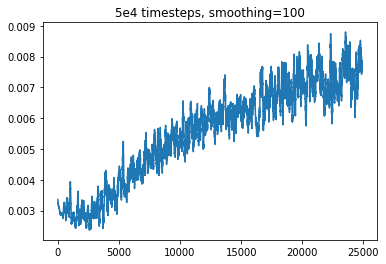

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [7]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec, kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()

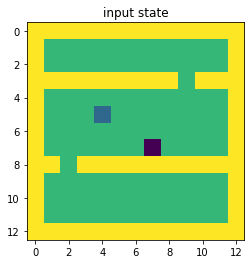

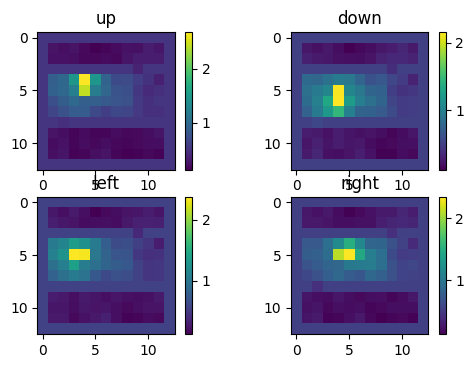

In [8]:
from deep_rl_old.component.fourrooms import FourRoomsMatrix
env = FourRoomsMatrix()
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
# env.current_cell = (5,5)
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [9]:
params_count(avdsr.network.psi2q)

169

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [10]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [11]:
def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [12]:
r_c0 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=0)
r_c1 = runNAgents(dsr_feature_init, runs=2, freeze=2, ref=avdsr, style=1)
r_dqn_base_16 = runNAgents(dqn_feature, runs=2)

runs:   0%|          | 0/2 [00:00<?, ?it/s]

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-11-28 15:57:18,284 - root - INFO: steps 0, episodic_return_test -180.30(18.69)
2020-11-28 15:57:25,346 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-11-28 15:57:32,474 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-11-28 15:57:39,587 - root - INFO: steps 15000, episodic_return_test -180.70(18.31)
2020-11-28 15:57:46,211 - root - INFO: steps 20000, episodic_return_test -7.00(1.33)
2020-11-28 15:57:52,894 - root - INFO: steps 25000, episodic_return_test -7.60(1.42)
2020-11-28 15:57:59,607 - root - INFO: steps 30000, episodic_return_test -8.30(1.33)
2020-11-28 15:58:06,310 - root - INFO: steps 35000, episodic_return_test -8.70(1.70)
2020-11-28 15:58:12,976 - root - INFO: steps 40000, episodic_return_test -6.70(0.95)
2020-11-28 15:58:19,657 - root - INFO: steps 45000, episodic_return_test -7.70(1.43)
2020-11-28 15:58:26,388 - root - INFO: steps 50000, episodic_return_test -8.50(1.08)
runs:  50%|█████     | 1/2 [01:08<01:08, 68.76s/it]

IncompatibleKeys(missing_keys=[], unexpected_keys=[])


2020-11-28 15:58:27,053 - root - INFO: steps 0, episodic_return_test -180.30(18.69)
2020-11-28 15:58:34,186 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-11-28 15:58:41,666 - root - INFO: steps 10000, episodic_return_test -121.10(30.56)
2020-11-28 15:58:49,355 - root - INFO: steps 15000, episodic_return_test -63.80(28.20)
2020-11-28 15:58:57,731 - root - INFO: steps 20000, episodic_return_test -64.60(28.04)
2020-11-28 15:59:04,929 - root - INFO: steps 25000, episodic_return_test -5.70(1.30)
2020-11-28 15:59:12,464 - root - INFO: steps 30000, episodic_return_test -7.50(1.64)
2020-11-28 15:59:20,088 - root - INFO: steps 35000, episodic_return_test -5.30(1.34)
2020-11-28 15:59:27,602 - root - INFO: steps 40000, episodic_return_test -4.70(0.72)
2020-11-28 15:59:34,944 - root - INFO: steps 45000, episodic_return_test -6.40(1.30)
2020-11-28 15:59:41,633 - root - INFO: steps 50000, episodic_return_test -7.60(1.70)
runs:   0%|          | 0/2 [00:00<?, ?it/s]

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2020-11-28 15:59:42,546 - root - INFO: steps 0, episodic_return_test -180.10(18.88)
2020-11-28 15:59:50,013 - root - INFO: steps 5000, episodic_return_test -120.90(30.64)
2020-11-28 15:59:57,099 - root - INFO: steps 10000, episodic_return_test -4.90(0.85)
2020-11-28 16:00:04,212 - root - INFO: steps 15000, episodic_return_test -5.00(0.51)
2020-11-28 16:00:11,367 - root - INFO: steps 20000, episodic_return_test -25.60(18.43)
2020-11-28 16:00:18,694 - root - INFO: steps 25000, episodic_return_test -83.60(30.06)
2020-11-28 16:00:25,939 - root - INFO: steps 30000, episodic_return_test -25.70(18.41)
2020-11-28 16:00:33,039 - root - INFO: steps 35000, episodic_return_test -8.40(1.40)
2020-11-28 16:00:40,202 - root - INFO: steps 40000, episodic_return_test -8.00(0.81)
2020-11-28 16:00:47,338 - root - INFO: steps 45000, episodic_return_test -6.90(1.49)
2020-11-28 16:00:54,493 - root - INFO: steps 50000, episodic_return_test -7.00(0.86)
runs:  50%|█████     | 1/2 [01:12<01:12, 72.86s/it]

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias'], unexpected_keys=['psi2q.w'])


2020-11-28 16:00:55,301 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-11-28 16:01:02,895 - root - INFO: steps 5000, episodic_return_test -180.80(18.21)
2020-11-28 16:01:10,352 - root - INFO: steps 10000, episodic_return_test -121.90(30.25)
2020-11-28 16:01:17,699 - root - INFO: steps 15000, episodic_return_test -64.50(28.08)
2020-11-28 16:01:24,908 - root - INFO: steps 20000, episodic_return_test -45.00(24.54)
2020-11-28 16:01:31,982 - root - INFO: steps 25000, episodic_return_test -5.30(0.74)
2020-11-28 16:01:39,178 - root - INFO: steps 30000, episodic_return_test -27.50(18.25)
2020-11-28 16:01:46,263 - root - INFO: steps 35000, episodic_return_test -6.10(1.46)
2020-11-28 16:01:53,388 - root - INFO: steps 40000, episodic_return_test -10.40(1.25)
2020-11-28 16:02:00,501 - root - INFO: steps 45000, episodic_return_test -10.30(1.10)
2020-11-28 16:02:07,613 - root - INFO: steps 50000, episodic_return_test -9.10(1.77)
runs:   0%|          | 0/2 [00:00<?, ?it/s]2020-11-28 

In [13]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(16,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

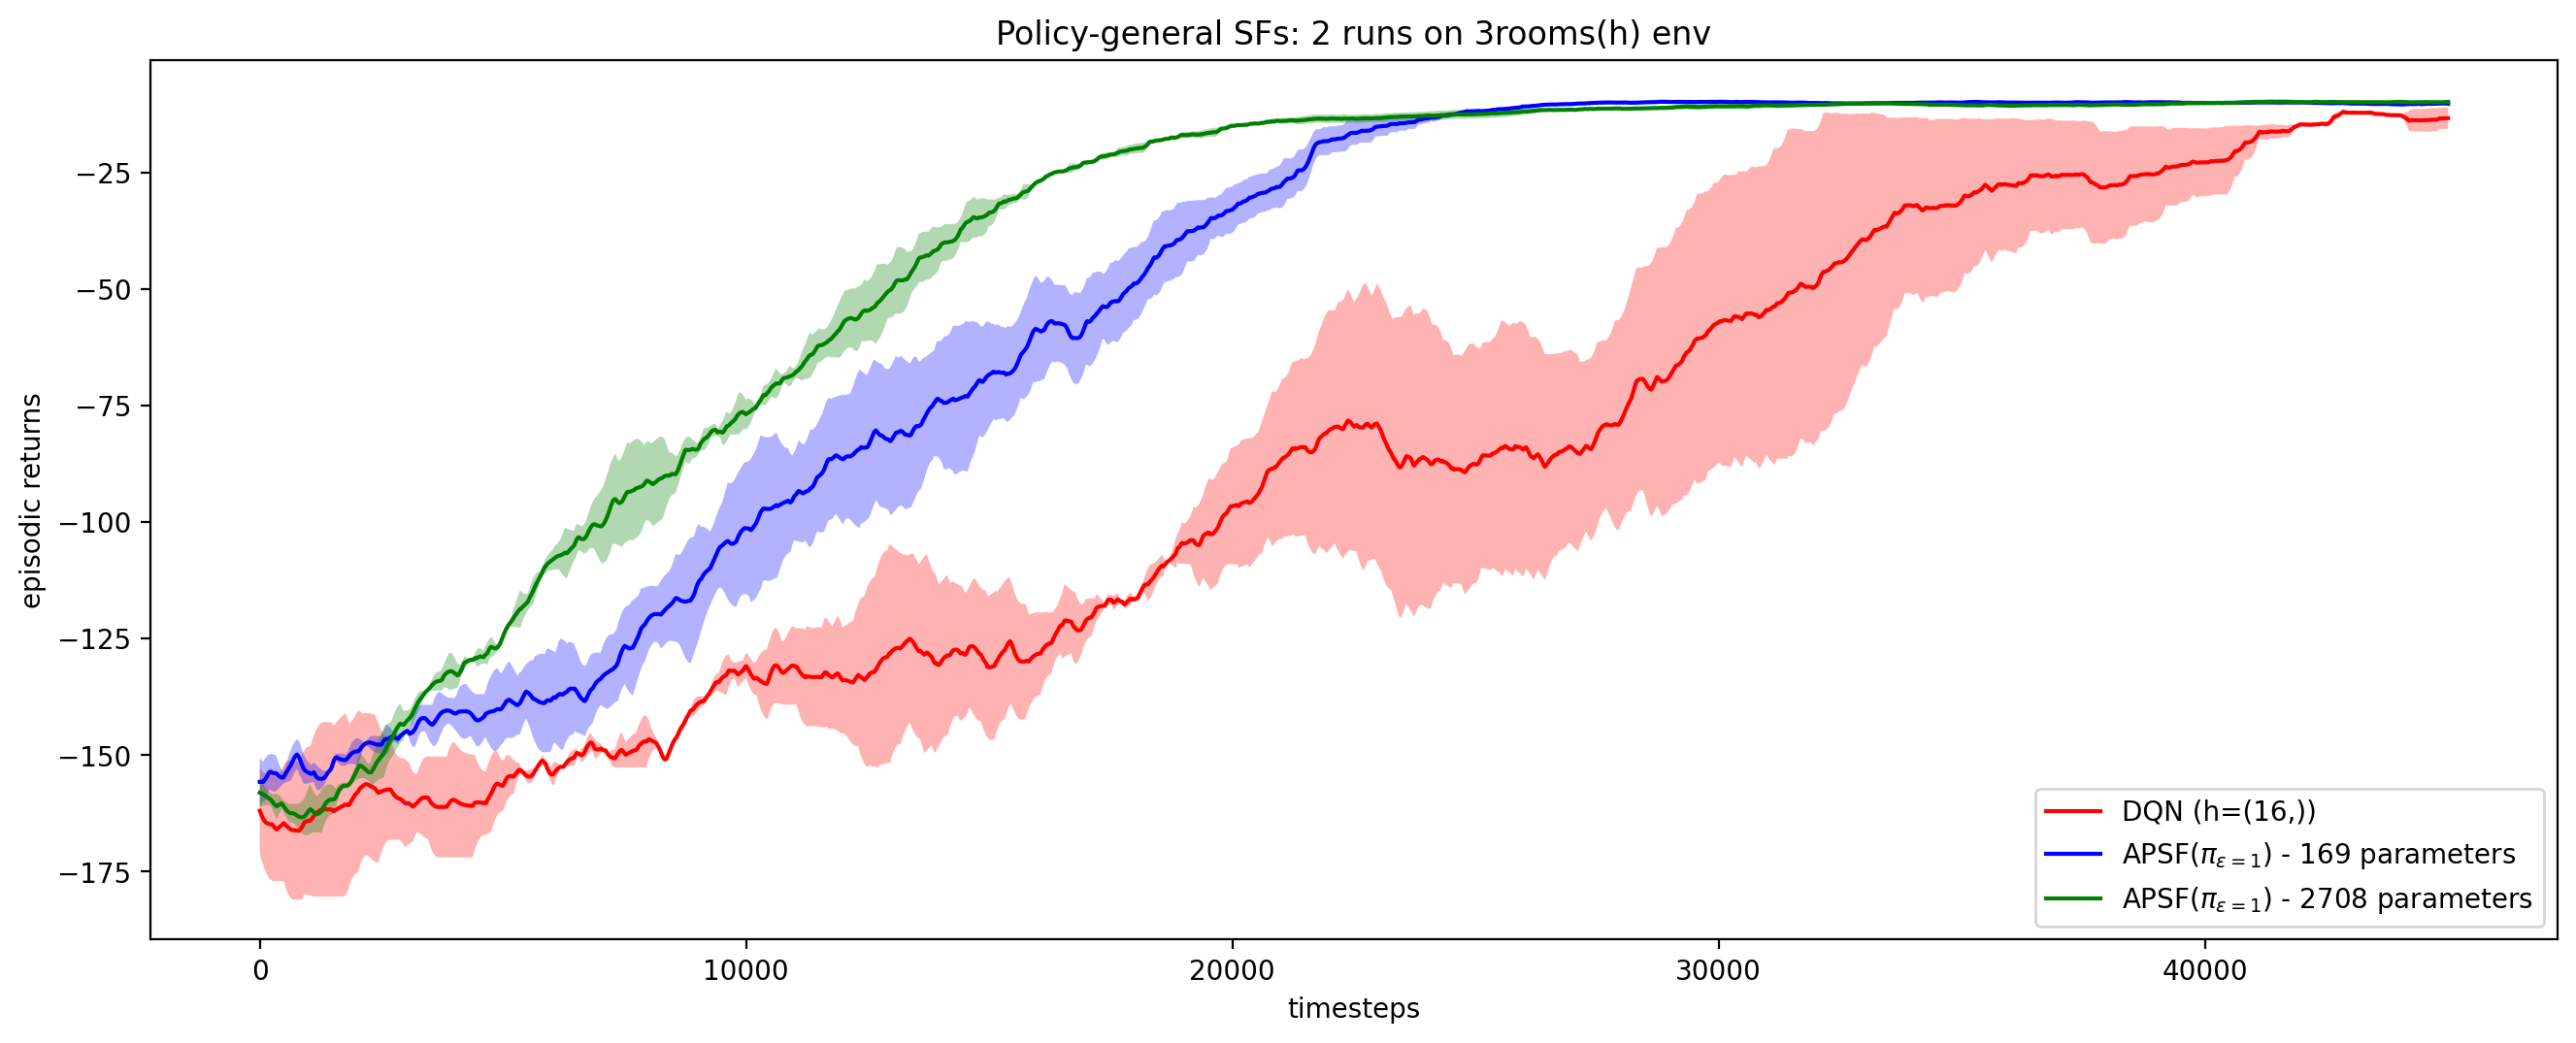

In [14]:
rewards_dict = {'DQN (h=(16,))': r_dqn_base_16[1:],
                'APSF($\pi_{\epsilon=1}$) - 169 parameters': r_c0[1:],
                'APSF($\pi_{\epsilon=1}$) - 2708 parameters': r_c1[1:],
               }

plot_rewards(rewards_dict, plot_seperate=False, title='Policy-general SFs: 2 runs on 3rooms(h) env')

### Sanity checks for learnt SRs

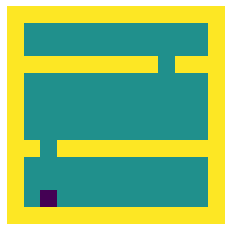

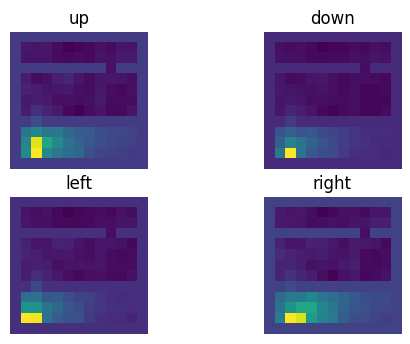

In [15]:
from deep_rl_old.component.fourrooms import *
# import matplotlib
# matplotlib.rc('axes',edgecolor='black')
g = [21, 28, 84, 91]
env = FourRoomsMatrix()
state = env.reset(init=g[3])
plt.imshow(env.render(show_goal=False))
plt.axis('off')
# plt.savefig('../storage/fig5.4-f.png')
plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.axis('off')
# plt.suptitle('Fine-tuning: '+ str(iters) + ' iterations')
plt.show()

In [30]:
# g = [21, 28, 84, 91]
c = np.ones(101)*4
# Set colors based on the environment here.
room1 = list(range(0,22))
room2 = list(range(23,67)) 
room3 = list(range(68,101))
connect = [22, 67]
c[room1] = 2
c[room2] = 3
c[room3] = 4
c[connect] = [-1, -1]
env = FourRoomsMatrix()
psi_all = np.zeros((101,169*4))
for i in range(101):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

(101, 676)

Text(0.5, 1.0, 'Principle components of SFs using PCA')

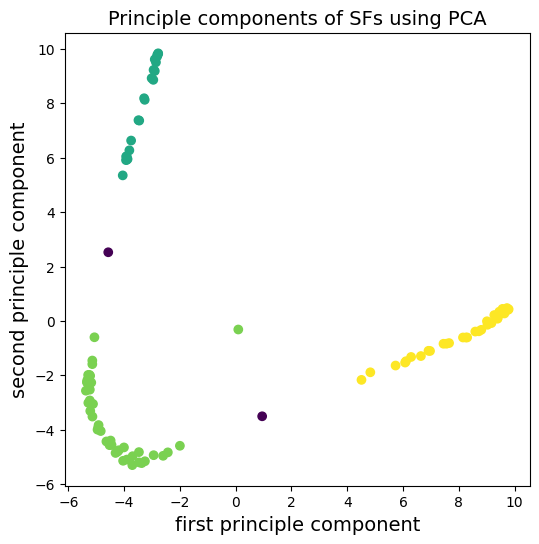

In [31]:
from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
# plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)